# US Monthly Residential Energy Consumption (Total)- Time Series Analysis (ARIMA predictions)

#### Context
The US Government has collected monthly data on energy consumption starting all the way back to 1973. This notebook will be a time series exploration of the total energy consumption focusing on the residential sector up until June 2021. Historical data will be used to build a SARIMAX model to forecast residential energy consumption for the next 5 years.


#### Dataset

Source: https://catalog.data.gov/dataset/monthly-and-annual-energy-consumption-by-sector

- Month                                             
- Primary Energy Consumed by the Residential Sector        
- Total Energy Consumed by the Residential Sector              
- Primary Energy Consumed by the Commercial Sector             
- Total Energy Consumed by the Commercial Sector             
- Primary Energy Consumed by the Industrial Sector            
- Total Energy Consumed by the Industrial Sector           
- Primary Energy Consumed by the Transportation Sector       
- Total Energy Consumed by the Transportation Sector         
- Primary Energy Consumed by the Electric Power Sector       
- Energy Consumption Balancing Item                           
- Primary Energy Consumption Total 

---

In [1]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import itertools
import math

%matplotlib inline
sns.set_style('darkgrid')
plt.rcParams.update({'figure.figsize': (15,8)})
import warnings
warnings.filterwarnings('ignore')

#### Data Cleaning
---

In [2]:
# Import dataset into notebook, store it in 'df'
df = pd.read_excel('Table_2.1_Energy_Consumption_by_Sector.xlsx')

In [3]:
# A Look at the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 12 columns):
 #   Column                                                Non-Null Count  Dtype         
---  ------                                                --------------  -----         
 0   Month                                                 582 non-null    datetime64[ns]
 1   Primary Energy Consumed by the Residential Sector     582 non-null    float64       
 2   Total Energy Consumed by the Residential Sector       582 non-null    float64       
 3   Primary Energy Consumed by the Commercial Sector      582 non-null    float64       
 4   Total Energy Consumed by the Commercial Sector        582 non-null    float64       
 5   Primary Energy Consumed by the Industrial Sector      582 non-null    float64       
 6   Total Energy Consumed by the Industrial Sector        582 non-null    float64       
 7   Primary Energy Consumed by the Transportation Sector  582 non-null    float64   

- There are a total of 582 entries with 12 columns.
- No NULL values are found in this dataset.
- Month is already in datetime format.
- All other columns are in float datatype.

In [4]:
# In this analysis, only the total energy consumption by the residential sector will be used
df = df[['Month', 'Total Energy Consumed by the Residential Sector']]

# Columns will be renamed for easier access
df.rename(columns={'Month':'Date', 'Total Energy Consumed by the Residential Sector':'Residential'}, inplace=True)

# Set date to index
df.set_index(pd.to_datetime(df.Date), inplace=True)

# Delete Date column
df.drop('Date', axis=1, inplace=True)

#### Data Exploration
---

In [5]:
# Quick look at restructured dataset
df.head()

,Residential
Date,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326


In [6]:
# Quick look at descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Residential,582.0,1551.07733,405.285073,901.7,1248.60425,1466.132,1812.57125,2808.412


- The average energy consumption is about 1551 BTU.
- The standard deviation is about 405 BTU.
- The mean is larger than the median value, 1466, maybe indicating some outliers to the right.
- The range is about 1900 BTU.

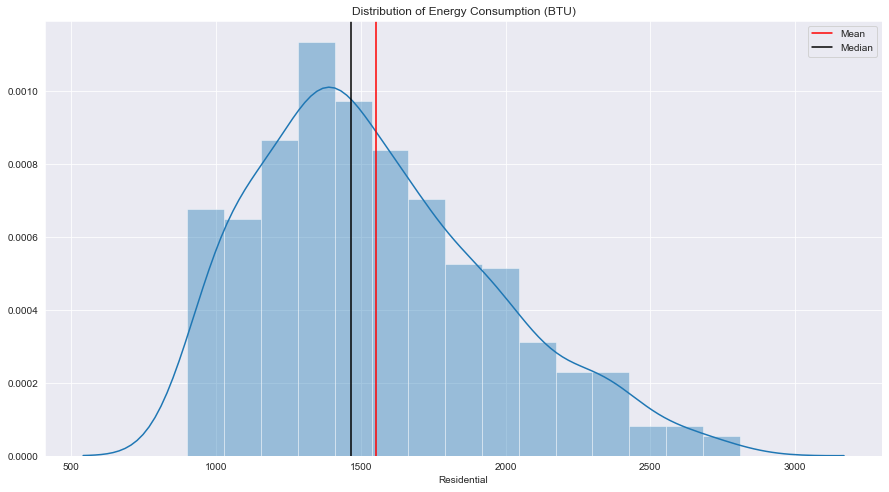

In [7]:
# A look at the distribution of energy consumption
sns.distplot(df['Residential'])
plt.axvline(df['Residential'].mean(), color='red', label='Mean')
plt.axvline(df['Residential'].median(), color='black', label='Median')
plt.title('Distribution of Energy Consumption (BTU)')
plt.legend(loc='best')
plt.show()

- The distribution of energy consumption is not normally distributed.
- The distribution is skewed to the right. High energy use is less common.

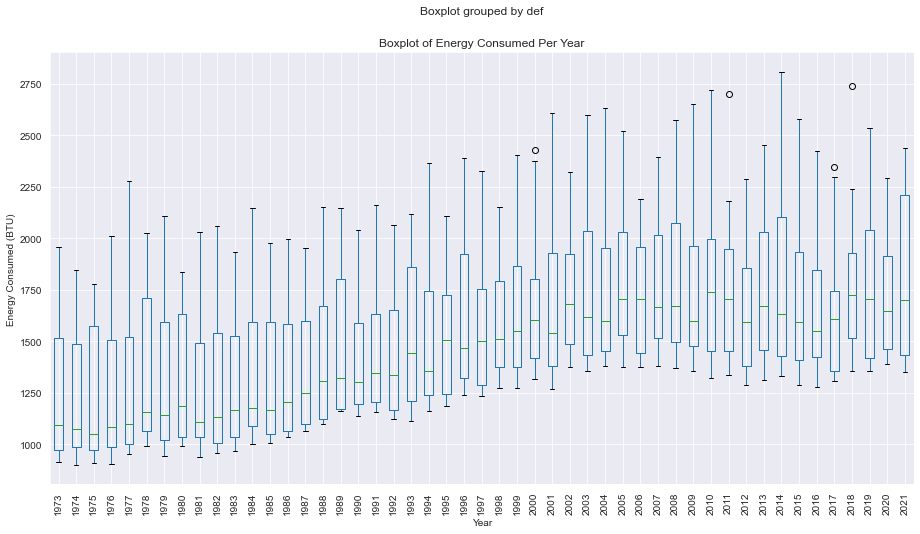

In [8]:
# Checking the distribution of sales across each year
df_copy = df.copy()
df_copy['def'] = df_copy.index.to_period('Y')
df_copy.boxplot(by='def')
plt.title('Boxplot of Energy Consumed Per Year')
plt.xlabel('Year')
plt.ylabel('Energy Consumed (BTU)')
plt.xticks(rotation=90)
plt.show()

- There is a general increase in median values every year, fluctuating around 1550 BTU.
- A few years have outliers, but at different points.
- The variance in consumption is larger from the 50% to 100%.

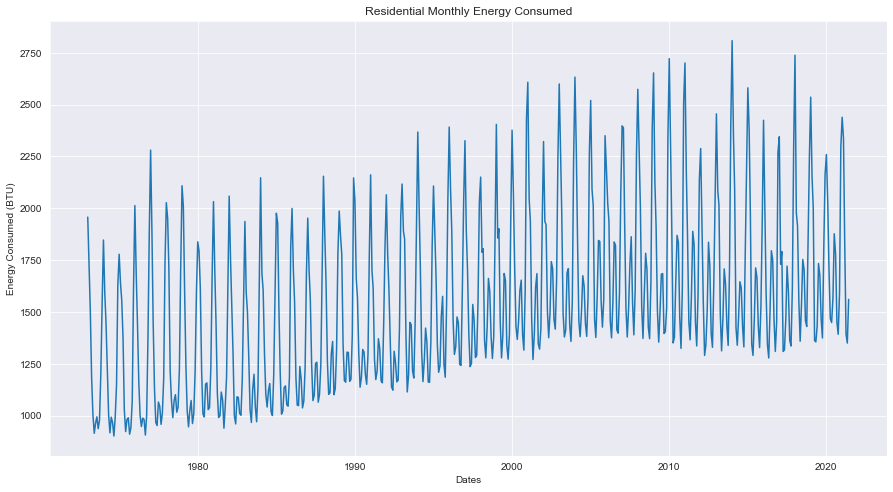

In [9]:
# Plotting Sales data
plt.plot(df['Residential'])
plt.title('Residential Monthly Energy Consumed')
plt.xlabel('Dates')
plt.ylabel('Energy Consumed (BTU)')
plt.show()

- There seems to be an upward trend in energy consumption.
- There also seems to be seasonality over an annual period. 
- The second peaks tend to get larger over the years, indicating a multiplicative property.

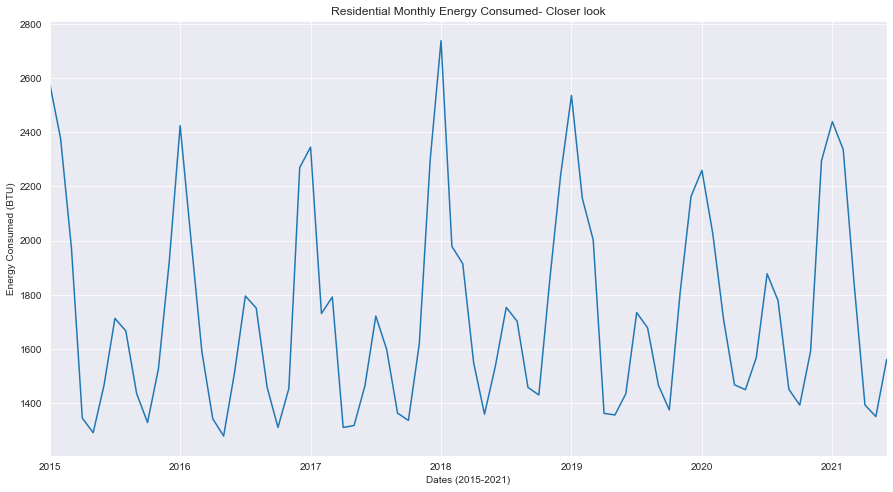

In [10]:
# A closer look (5 year span) of the cycle
df['Residential']['2015':'2021'].plot()
plt.title('Residential Monthly Energy Consumed- Closer look')
plt.xlabel('Dates (2015-2021)')
plt.ylabel('Energy Consumed (BTU)')
plt.show()

- Energy consumption is at its highest peak at the start of every year.
- Consumption dips considerably towards the summer period, with a small uptick.
- Towards the fall and winter, consumption spikes rapidly to its peak.

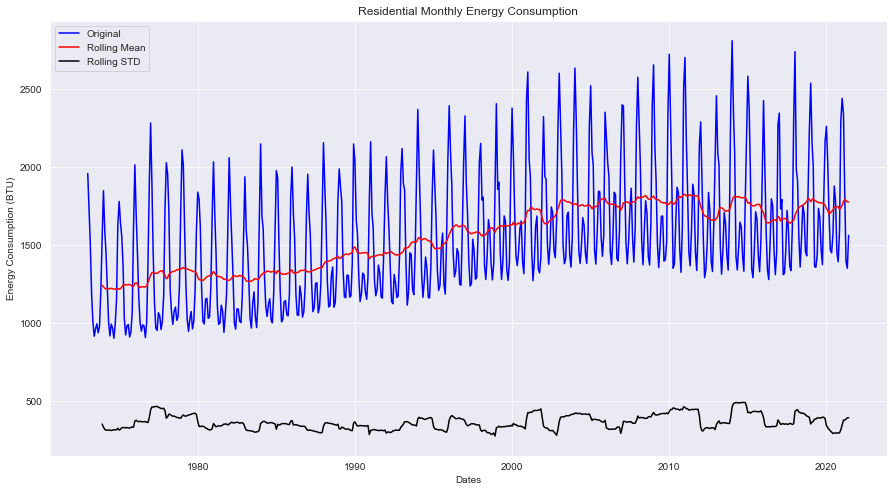

In [11]:
# Plotting original data
plt.plot(df['Residential'], color='blue', label='Original')
# PLotting rolling mean of Sales
plt.plot(df['Residential'].rolling(12).mean(), color='red', label='Rolling Mean')
# Plotting rolling standard deviation of Sales
plt.plot(df['Residential'].rolling(12).std(), color='black', label='Rolling STD')

plt.title('Residential Monthly Energy Consumption')
plt.xlabel('Dates')
plt.ylabel('Energy Consumption (BTU)')
plt.legend(loc='best')

plt.show()

- A 12 month rolling average shows a slight increasing trend.
- The rolling standard deviation is varying yearly therefore there is some variance.
- Both are not constant, suggesting it is non-stationary.

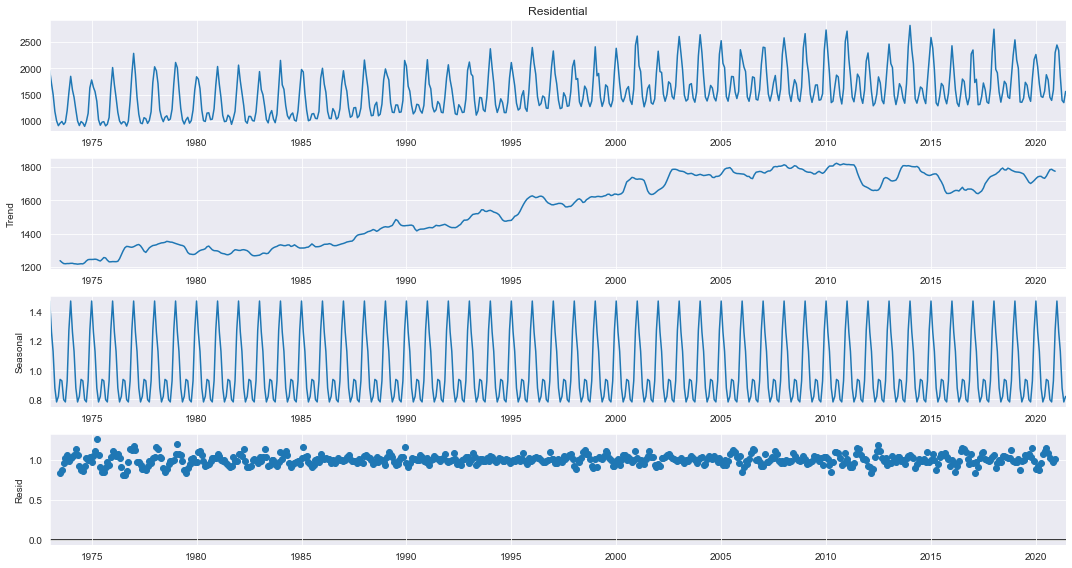

In [12]:
# Decomposing and isolating consumption data into trend, season, and residuals. 
seasons = seasonal_decompose(df['Residential'], model='multiplicative', period=12)
seasons.plot()
plt.show()

- Decomposition confirms that there is an upward trend.
- Decomposition also confirms there is clear seasonality, cycling every year.
- There is no pattern in the residuals.

#### Finding SARIMAX Orders
---

In [13]:
# Checking consumption data for stationarity with Adfuller test
stationary = adfuller(df['Residential'])

print('t-statistic:', stationary[0], 
     '\np-value:', stationary[1],
     '\ncritical values:', stationary[4])

if stationary[1] > 0.05:
    print('\nNot Stationary')
else:
    print('\nStationary')

t-statistic: -1.3238926148742793 
p-value: 0.6181717716963261 
critical values: {'1%': -3.4418948967017475, '5%': -2.8666329082535222, '10%': -2.569482366838501}

Not Stationary


- The energy consumption data is not initially stationary, with a unit root.
- The t-statistic is not extreme enough compared to the critical values.
- The p-value (0.618) is > 0.05.
- Differencing will be needed to create a stationary series.

In [14]:
# Checking consumption data for stationarity after differencing
stationary = adfuller(df['Residential'].diff(periods=1).dropna())

print('t-statistic:', stationary[0], 
     '\np-value:', stationary[1],
     '\ncritical values:', stationary[4])

if stationary[1] > 0.05:
    print('\nNot Stationary')
else:
    print('\nStationary')

t-statistic: -14.816490836070928 
p-value: 1.993551523633035e-27 
critical values: {'1%': -3.4418948967017475, '5%': -2.8666329082535222, '10%': -2.569482366838501}

Stationary


- Differencing the consumption data by one lag creates a stationary series with a p-value < 0.05.
- The t-statistic (-14.8) is also much smaller than each of the critical values.
- The d in ARIMA orders is equal to 1.
- However, the time series also has a seasonal component.

In [15]:
# Checking consumption data for stationarity after differencing out a lag of 12
stationary = adfuller(df['Residential'].diff(periods=12).dropna())

print('t-statistic:', stationary[0], 
     '\np-value:', stationary[1],
     '\ncritical values:', stationary[4])

if stationary[1] > 0.05:
    print('\nNot Stationary')
else:
    print('\nStationary')

t-statistic: -8.259251063434421 
p-value: 5.136307849323575e-13 
critical values: {'1%': -3.4421660928041633, '5%': -2.8667523104859627, '10%': -2.56954599309042}

Stationary


- Differencing the consumption data by 12 lags creates a stationary series with a p-value < 0.05.
- The t-statistic (5.14e-13) is also much smaller than each of the critical values.
- The D in seasonal ARIMA orders is equal to 1.

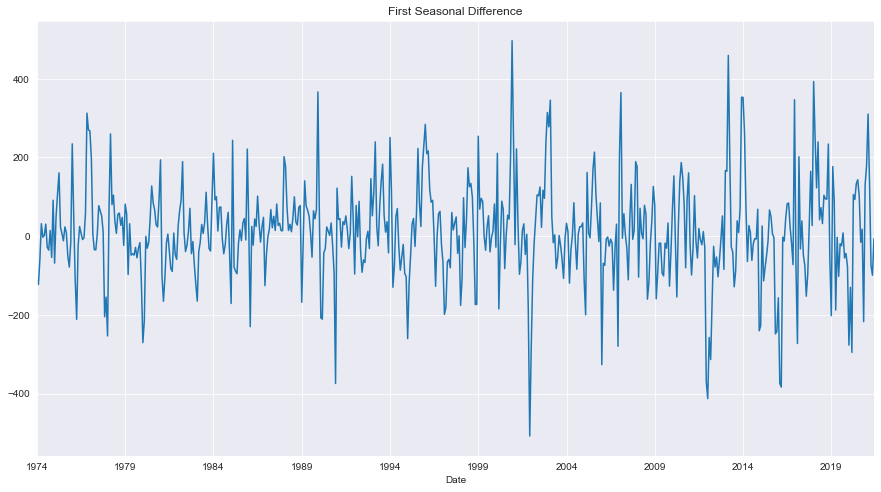

In [16]:
# A look at the seasonal difference plot
df['Residential'].diff(periods=12).dropna().plot()

plt.title('First Seasonal Difference')
plt.xlabel('Date')
plt.show()

- There is now no trend or seasonality.
- The mean and variance fluctuates around 0.

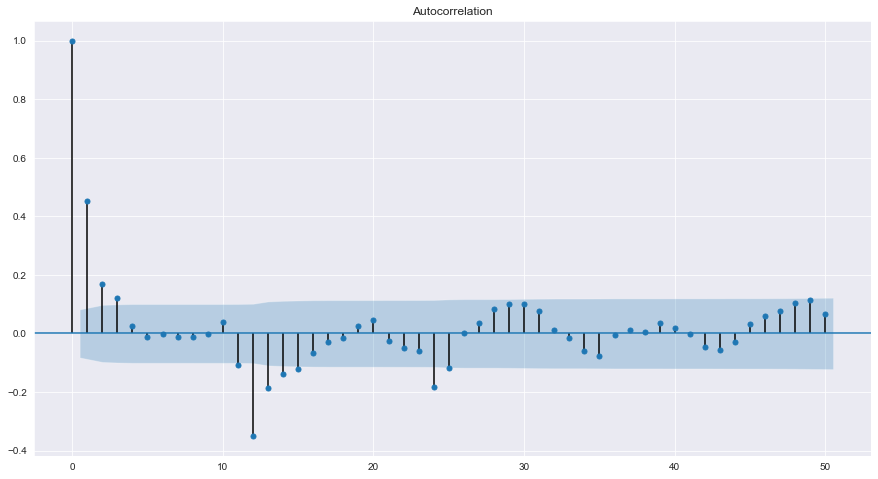

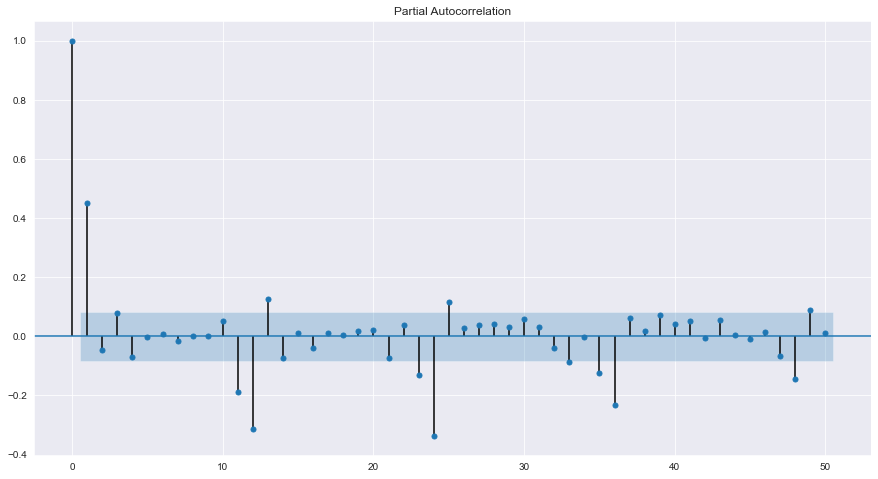

In [17]:
# Plot the ACF and PACF to see autocorrelations
plot_acf(df['Residential'].diff(periods=12).dropna(), lags=50)
plot_pacf(df['Residential'].diff(periods=12).dropna(), lags=50)

plt.show()

In [18]:
# Using a grid search to find seasonal ARIMA orders
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

first_order = []
second_order = []
aic = []

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(df['Residential'],
                               order=param,
             seasonal_order=param_seasonal,
                enforce_stationarity=False,
               enforce_invertibility=False)

            results = model.fit()
            
            first_order.append(param)
            second_order.append(param_seasonal)
            aic.append(results.aic)
            
        except:
            continue

orders = pd.DataFrame(data=list(zip(first_order, second_order, aic)), columns=['order', 'seasonal_order', 'AIC'])

# Print out the 5 parameters with the lowest AIC value
orders.sort_values(by='AIC', ascending=True).head()

,order,seasonal_order,AIC
59,"(1, 1, 1)","(0, 1, 1, 12)",6590.053257
63,"(1, 1, 1)","(1, 1, 1, 12)",6591.345104
43,"(1, 0, 1)","(0, 1, 1, 12)",6637.880093
47,"(1, 0, 1)","(1, 1, 1, 12)",6639.243567
35,"(1, 0, 0)","(0, 1, 1, 12)",6647.757697


- Grid search using the SARIMAX model reveals that order: (1,1,1)/ seasonal_order: (0,1,1,12) offer the best model with an AIC of 6590.05.

In [19]:
# Using Auto_arima to find the best orders
model = auto_arima(df['Residential'],
                  trace=True,
                  test='adf',
                  error_action='ignore',
                  suppress_warnings=True, 
                  start_p=0,
                  d=1,
                  start_q=0, 
                  m=12, 
                  start_P=0,
                  D=1,
                  start_Q=0)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7156.992, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7042.001, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6841.927, Time=0.90 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=7078.531, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=6840.894, Time=1.30 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=7003.231, Time=0.42 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=6820.216, Time=3.79 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=6917.717, Time=1.68 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=6814.623, Time=29.58 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=6835.546, Time=9.94 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=6900.166, Time=5.14 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=13.10 sec
 ARIMA(0,1,2)(2,1,2)[12]             : AIC=inf, Time=11.54 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=6865.805, Time=5.79 sec
 ARIMA(1,1,2)(2,1,2)[12]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  582
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -3366.112
Date:                            Wed, 27 Oct 2021   AIC                           6748.224
Time:                                    12:00:38   BIC                           6782.975
Sample:                                         0   HQIC                          6761.783
                                            - 582                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3770      0.080      4.726      0.000       0.221       0.533
ma.L1         -0.8751      0.083    -10.554      0.000      -1.038      -0.713
ma.L2         -0.0924      0.078     -1.192      0.233      -0.244       0.060
ar.S.L12       0.7853      0.138      5.697      0.000       0.515       1.056
ar.S.L24      -0.1376      0.041     -3.365      0.001      -0.218      -0.057
ma.S.L12      -1.5923      0.133    -11.965      0.000      -1.853      -1.331
ma.S.L24       0.6681      0.110      6.088      0.000       0.453       0.883
sigma2      7549.8512    336.939     22.407      0.000    6889.464    8210.239
===================================================================================
Ljung-Box (Q):                       44.53   Jarque-Bera (JB):               113.21
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Using auto_arima reveals that order: (1,1,2)/ seasonal_order: (2,1,2,12) offers the best model with an AIC of 6748.22. 
- The AIC value is larger than the one found using the Grid Search, therefore the orders found before will be used.

#### Validating model with training/testing set
---

In [20]:
# Split data: last 12 months (1 year) as testing set, and everything before as the training set
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

print(train.shape, test.shape)

(570, 1) (12, 1)


In [21]:
# Create SARIMAX model on the training dataset using the orders found in the grid search
model = SARIMAX(train['Residential'], order=(1,1,1), seasonal_order=(0,1,1,12))
result = model.fit()

# Print the summary
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Residential   No. Observations:                  570
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3307.149
Date:                            Wed, 27 Oct 2021   AIC                           6622.298
Time:                                    12:00:39   BIC                           6639.588
Sample:                                01-01-1973   HQIC                          6629.051
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5292      0.029     18.125      0.000       0.472       0.586
ma.L1         -0.9994      0.022   

- The resulting model (trained on the training set) yields an AIC of 6622.3.

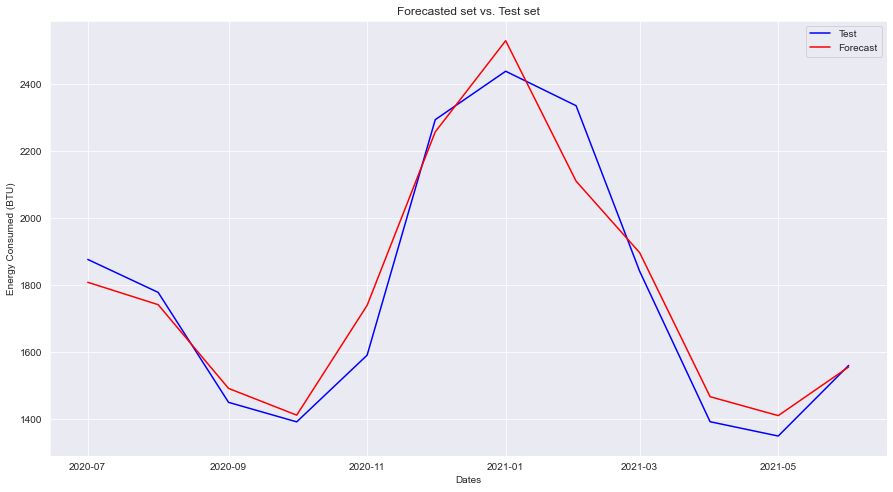

In [22]:
# Predict sales for the 12 month testing period
validation = pd.DataFrame(data=result.predict(start=len(train), end=len(train)+len(test)-1,dynamic=True).values, columns=test.columns, index=test.index)

# Plot the testing set to the predicted set
plt.plot(test['Residential'], color='blue', label='Test')
plt.plot(validation, color='red', label='Forecast')
plt.title('Forecasted set vs. Test set')
plt.xlabel('Dates')
plt.ylabel('Energy Consumed (BTU)')
plt.legend(loc='best')
plt.show()

- The predicted set closely follows the test set, slightly overestimating/ underestimating at some points.

In [23]:
# Checking error values of predictions to test values
rmse = math.sqrt(mean_squared_error(test, validation))
mape = np.mean(np.abs(validation - test)/np.abs(test))

print('RMSE:', rmse, '\nMAPE:', mape)

RMSE: 92.61561231059214 
MAPE: Residential    0.039581
dtype: float64


- Our validation forecast yields a low RMSE score of 92.6 as well as a low MAPE percentage of 0.04.

#### Building SARIMAX model & Forecasting for the next 5 years
---

                                     SARIMAX Results                                      
Dep. Variable:                        Residential   No. Observations:                  582
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3372.844
Date:                            Wed, 27 Oct 2021   AIC                           6753.687
Time:                                    12:00:43   BIC                           6771.063
Sample:                                01-01-1973   HQIC                          6760.467
                                     - 06-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4446      0.034     12.926      0.000       0.377       0.512
ma.L1         -0.9656      0.012   

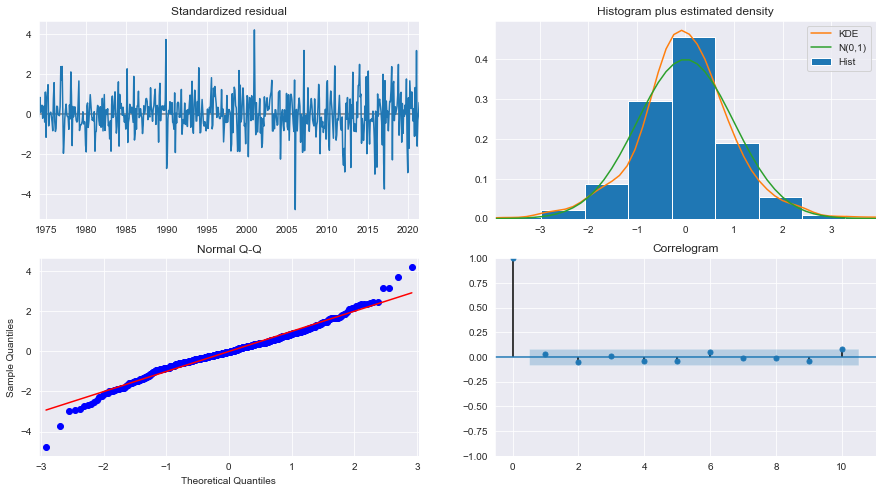

In [24]:
# Build SARIMAX model after validation is satisfactory
model = SARIMAX(df['Residential'], order=(1,1,1), seasonal_order=(0,1,1,12))
result = model.fit()

print(result.summary())

result.plot_diagnostics()
plt.show()

- Using SARIMAX to train the training set results in an AIC of 6622.298.
- The top left graph shows that the residuals over time display no seasonality and fluctuate a mean/ variance around 0.
- In the top right, the residuals are almost normally distributed, notated by the green line.
- The bottom left QQ-plot, the residuals follow a linear trend, with no extreme skews.
- The bottom right correlogram shows that the residuals have low correlations with its lags.
- The model seems to be a good fit for the dataset.

In [25]:
# Creating a dataframe for new future dates - 60 months (5 years)
new_dates=[df.index[-1]+DateOffset(months=x) for x in range(1,60)]
df_pred = pd.DataFrame(index = new_dates, columns = df.columns)
df_pred.head()

,Residential
2021-07-01,NaN
2021-08-01,NaN
2021-09-01,NaN
2021-10-01,NaN
2021-11-01,NaN


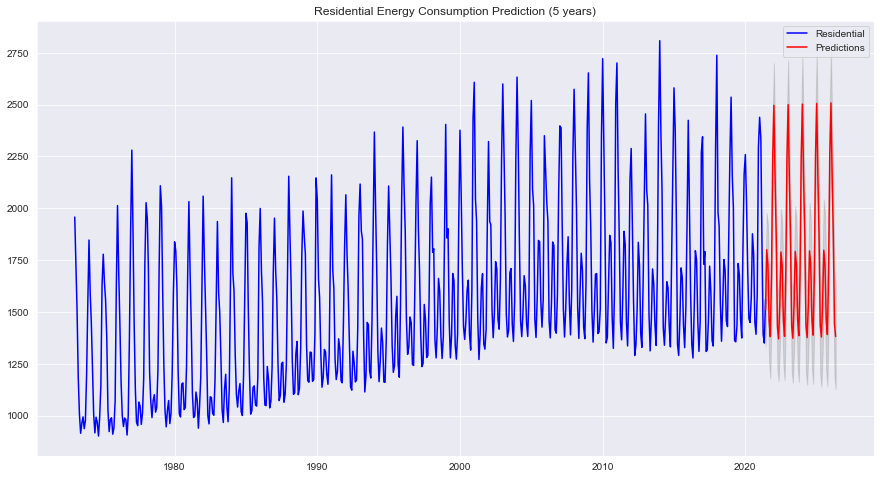

In [26]:
# Concatenating original dataset with the dataset for new dates
df2 = pd.concat([df, df_pred])

# Predicting Sales and confidence intervals
df2['predictions'] = result.get_prediction(start=len(df)-1, end=len(df)+59).summary_frame()['mean']
df2['upper_limit'] = result.get_prediction(start=len(df)-1, end=len(df)+59).summary_frame()['mean_ci_upper']
df2['lower_limit'] = result.get_prediction(start=len(df)-1, end=len(df)+59).summary_frame()['mean_ci_lower']

#Plotting Original data, predictions, and confidence intervals
plt.plot(df2['Residential'], color='blue', label='Residential')
plt.plot(df2['predictions'], color='red', label='Predictions')
plt.fill_between(df2.index, df2['upper_limit'], df2['lower_limit'], color='grey', alpha=.25)

plt.title('Residential Energy Consumption Prediction (5 years)')
plt.legend(loc='best')

plt.show()

- We see that the next 5 years of residential energy consumption seem to stabilize, maybe with a very slight upward trend.
- The increase in confidence intervals every year indicate less confidence as we get further away from the original series.

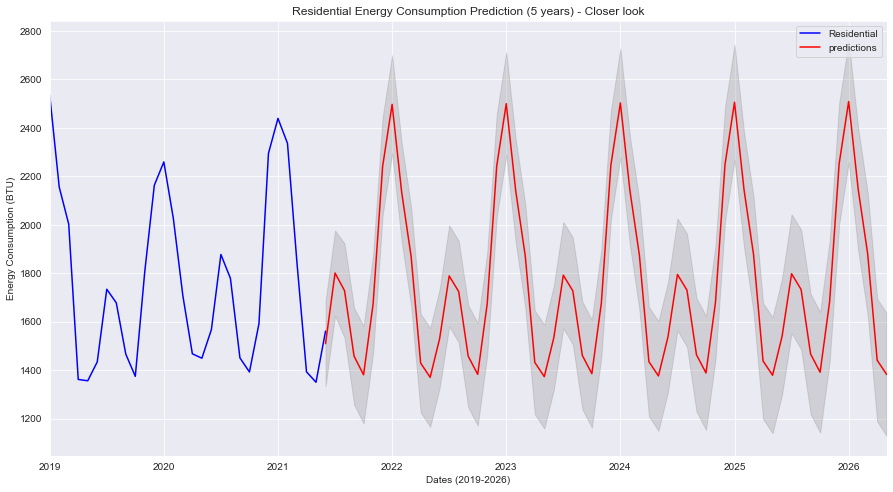

In [27]:
# Taking a closer look at the forecast
df2['Residential']['2019':'2021'].plot(color='blue')
df2['predictions']['2021':'2026'].plot(color='red')
plt.fill_between(df2.index, df2['upper_limit'], df2['lower_limit'], color='grey', alpha=.25)

plt.title('Residential Energy Consumption Prediction (5 years) - Closer look')
plt.xlabel('Dates (2019-2026)')
plt.ylabel('Energy Consumption (BTU)')

plt.legend(loc='best')
plt.show()